In [1]:
#mu 0.008697 (death), 0.0114 (birth), average 0.01 (annual; Source: https://www.cdc.gov/nchs/fastats/births.htm and https://www.cdc.gov/nchs/fastats/deaths.htm)
#mui 0.018 (452 days; Source: https://coronavirus.jhu.edu/data/mortality)
#beta 0.38 (Toda)
#gamma 0.1 (Toda)

#Note 1: While the model distinguishes fatalies caused by the infectious disease from other fatalities, there doesn't exist such a clear distinction in the data. 
#Thus, some fatalities allocated to COVID-19 in the data may in fact be from other causes.

#Note 2: General mortality rate is from 2019 data, while COVID-19 data is from 2020. Thus the time periods do not exactly coincide, but should give a reasonable estimate.

In [4]:
#converting to daily rates when necessary to match the calibration in Toda (2020)

import numpy as np

i = np.linspace(0.008/365, 0.012/365, num=10)
j= np.linspace(0.01/452, 0.03/452, num=10) #452 is number of days since Jan 20,2020 - first confirmed case of COVID-19 in the US (approximate)
k = np.linspace(0.2, 0.4, num=10)
l = np.linspace(0.08, 0.12, num=10)
m = np.linspace(0, 1, num=10)

In [26]:
countIpos = 0
countRneg = 0
for i in mu:
    for j in beta:
        for k in mui:
            for l in gamma:
                dIdmu = (k+l)/(i+k+l)**2 - 1/j
                dRdgamma = (k+i)/(i+k+l)**2 - 1/j
                if dIdmu > 0:
                    countIpos = countIpos+1
                if dRdgamma < 0:
                    countRneg = countRneg+1
print(countIpos)
print(countRneg)

# SIRS model

We have that 
- $\frac{\partial I}{\partial \mu}$ is negative for $\sigma$ around 0.13-1, and positive for $\sigma$ around 0-0.4, with both positive and negative value the remaining range. 
- $\frac{\partial R}{\partial \gamma}$ is negative for sigma less than 0.05, and both positive and negative for all other values.

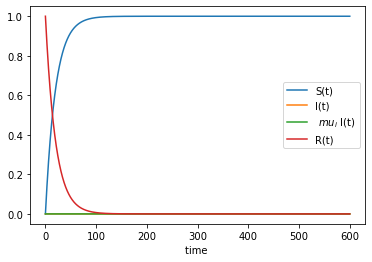

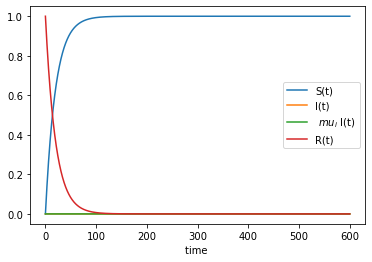

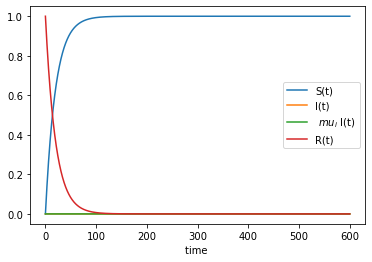

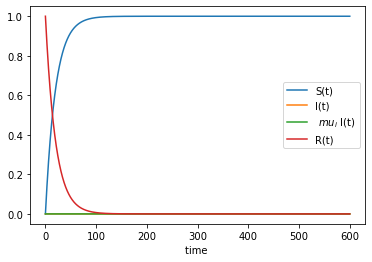

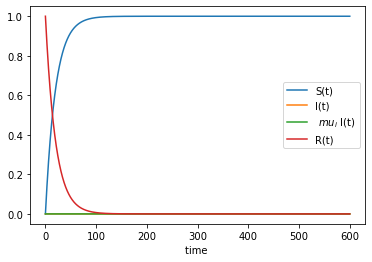

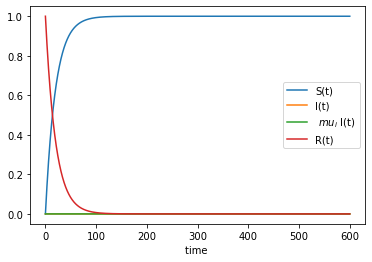

In [2]:
import numpy as np
from scipy . integrate import odeint
import matplotlib . pyplot as plt

beta = [0.1 , 0.9 , 0.5 , 1, 0.2 , 0.9]
gamma = [0.9 , 0.1 , 0.1 , 0.5 , 0.05 , 0.001]
mu = [0.05]*6
mu_i = [0.05 , 0.05 , 0.05 , 0.05 , 0.05 , 0.5]
for n in range (0 ,6):
    def sir(x,t):
        s = x[0]
        i = x[1]
        r = x[2]
        dsdt = mu[n] - beta [n]*s*i - mu[n]*s
        didt = beta [n]*s*i - (mu[n]+ gamma [n]+ mu_i [n])*i
        drdt = gamma [n]*i - mu[n]*r
        return [dsdt ,didt , drdt ]

    x0 = [0, 0, 1] # initial conditions used in Toda (2020)
    t = np. linspace (0, 600, 10000)

    x = odeint (sir ,x0 ,t)
    s=x[: ,0]
    i=x[: ,1]
    r=x[: ,2]
    plt. plot (t,s, label ="S(t)")
    plt. plot (t,i, label ="I(t)")
    plt. plot (t, mu_i [n]*i, label ="$\ mu_i$ I(t)")
    plt. plot (t,r, label ="R(t)")
    plt. xlabel ('time ')
    plt. legend ()
    #plt. savefig (str(n)+".png")
    plt. show ()

### import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

beta = [0.1, 0.9, 0.5, 0.9, 0.9,0.38]
gamma = [0.9, 0.1, 0.1, 0.4, 0.1, 0.1]
mu = [0.05, 0.05, 0.05, 0.05, 0.05,0.4]
mu_i = [0.05, 0.05, 0.05, 0.05, 0.05,0.5]
sigma =[0.25,0.5,0.75,0.1,0.9,0.5]
for n in range(0,5):
    def sir(x,t):
        s = x[0]
        i = x[1]
        r = x[2]
        dsdt = mu[n] - beta[n]*s*i - mu[n]*s + sigma[n]*r
        didt = beta[n]*s*i - (mu[n]+gamma[n]+mu_i[n])*i
        drdt = gamma[n]*i - (mu[n]+sigma[n])*r
        return [dsdt,didt,drdt]

    x0 = [0.99999999, 0.00000001, 0] #Toda initial conditions
    t = np.linspace(0, 150, 10000)
    x = odeint(sir,x0,t)

    s=x[:,0]
    i=x[:,1]
    r=x[:,2]
    plt.plot(t,s, label="S(t)")
    plt.plot(t,i, label="I(t)")
    plt.plot(t,mu_i[n]*i, label="$\mu_i$ I(t)")
    plt.plot(t,r, label="R(t)")
    plt.xlabel('time')
    plt.legend()

    plt.show()

In [1]:
%matplotlib auto

from typing import Tuple
import argparse
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt


class EEStability:
    def __init__(self,
                 beta: float,
                 mu: float,
                 gamma: float,
                 N: int = 1000,
                 mu_i_min: float = 1e-8,
                 mu_i_max: float = 1.-1e-8,
                 sigma_i_min: float = 1e-8,
                 sigma_i_max: float = 1.-1e-8) -> None:
        """Namespace for simulation of EE stability"""
        self.beta = beta
        self.mu = mu
        self.gamma = gamma

        self.N = N
        self.mu_i = np.linspace(mu_i_min, mu_i_max, N)
        self.sigma = np.linspace(sigma_i_min, sigma_i_max, N)

        self.matrices = None
        self.vals = None


    def get_matrices(self) -> np.array:
       """Returns Jacobian at EE"""
       self.matrices = np.zeros((self.N,self.N,3,3))
       for i in range(self.N):
           for j in range(self.N):
                self.matrices[i,j,0,0] = self.mu * (self.mu+self.mu_i[i]+self.gamma-self.beta) / \
                                           (self.mu + self.mu_i[i] + (self.mu*self.gamma) / (self.mu + self.sigma[j])) \
                                        - self.mu
                self.matrices[i,j,0,1] = -self.mu - self.mu_i[i] - self.gamma
                self.matrices[i,j,0,2] = self.sigma[j]
                self.matrices[i,j,1,0] = self.mu * (self.beta - self.mu - self.mu_i[i] - self.gamma) / \
                                       (self.mu + self.mu_i[i] + (self.mu*self.gamma) / (self.mu + self.sigma[j]))
                self.matrices[i,j,1,1] = 0.
                self.matrices[i,j,1,2] = 0.
                self.matrices[i,j,2,0] = 0.
                self.matrices[i,j,2,1] = self.gamma
                self.matrices[i,j,2,2] = -self.mu - self.sigma[j]
       return self.matrices


    def SVD(self) -> Tuple[np.array,np.array,np.array]:
        self.vals = np.zeros((self.N,self.N,3))
        for i in range(self.N):
            for j in range(self.N):
                self.vals[i,j,:], _ = LA.eig(self.matrices[i,j,:,:])
        return self.mu_i, self.sigma, self.vals


    def plot(self, **kwargs) -> None:
        mu_i, sigma = np.meshgrid(self.mu_i, self.sigma)
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        ax.plot_surface(mu_i, sigma, self.vals[:,:,0], label=r"$\lambda_1$")
        ax.plot_surface(mu_i, sigma, self.vals[:,:,1], label=r"$\lambda_2$")
        ax.plot_surface(mu_i, sigma, self.vals[:,:,2], label=r"$\lambda_3$")
        ax.set_xlabel(r"$\mu_i$", fontsize=20)
        ax.set_ylabel(r"$\sigma$", fontsize=20)
        ax.set_zlim(-1.5, 1.5)
        plt.show()


def main():
    example_params = {"beta": 0.4,
                      "mu": 0.1,
                      "gamma": 0.3}
    simulation = EEStability(**example_params)
    simulation.get_matrices()
    simulation.SVD()
    simulation.plot()


main()

Using matplotlib backend: MacOSX


In [9]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt


a = np.linspace(0.001, 1, 10)
b = np.linspace(0.001, 1, 10)
eecase=0
eecorrectcase=0
flag=0
for mu in a:
    for mu_i in a:
        for beta in b:
            for gamma in a:
                for sigma in a:
                    n=n+1

                    if beta > mu+mu_i+gamma:
                        eecase = eecase+1
                        s_star= (mu+mu_i+gamma)/beta
                        i_star = mu*(1-(mu+mu_i+gamma)/beta)/(mu+mu_i+mu*gamma/(mu+sigma))
                        r_star = mu*gamma*(1-(mu+mu_i+gamma)/beta)/((mu+mu_i)*(mu+sigma)+mu*gamma)
                        def sir(x,t):
                            s = x[0]
                            i = x[1]
                            r = x[2]
                            dsdt = mu - beta*s*i - mu*s + sigma*r
                            didt = beta*s*i - (mu+gamma+mu_i)*i
                            drdt = gamma*i - (mu+sigma)*r
                            return [dsdt,didt,drdt]

                        x0 = [s_star+0.001, i_star-0.001, r_star] 

                        t = np.linspace(0, 1200000, 10000)
                        x = odeint(sir,x0,t)
                        s=x[:,0]
                        i=x[:,1]
                        r=x[:,2]
                        if abs(s[9999]-s_star) < 0.0001 and abs(i[9999]-i_star) < 0.0001:
                            eecorrectcase= eecorrectcase+1
                        elif flag==0:
                            flag=1
                            print(beta)
                            print(mu)
                            print(mu_i)
                            print(gamma)
                            print(sigma)

print(n)
print(eecase)
print(eecorrectcase)

0.556
0.001
0.001
0.445
0.001
200000
4950
4416


In [27]:
import numpy as np

mu = 0.1
mu_i = 0.05
gamma = 0.4
sigma = 0.3
beta = np.linspace(0.1,0.9,200)
max_function = [0]*200

for n in range(0,200):
    max_function[n] = mu*((mu+mu_i+gamma)/beta[n]-1)/(mu+mu_i+(mu*gamma)/(mu+sigma))-mu*(mu+ mu_i+ gamma)/(6*beta[n]*beta[n]*(mu+mu_i+(mu*gamma)/(mu+sigma)))
    
maxval = 0
for n in range(0,200):
    if max_function[n] > max_function[maxval]:
        maxval = n
print(beta[maxval])

0.3331658291457287


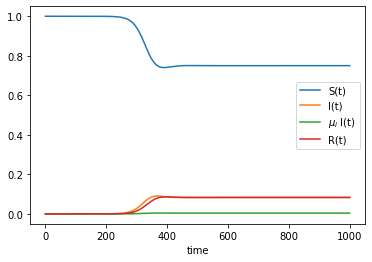

0.7500000000000001
0.7499999997230122


In [8]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt


mu = 0.05
mu_i = 0.05
gamma = 0.05
beta = 0.2
sigma = 0

def sir(x,t):
    s = x[0]
    i = x[1]
    r = x[2]
    dsdt = mu - beta*s*i - mu*s + sigma*r
    didt = beta*s*i - (mu+gamma+mu_i)*i
    drdt = gamma*i - (mu+sigma)*r
    return [dsdt,didt,drdt]

x0 = [0.99999999, 0.00000001, 0] #Toda initial conditions
t = np.linspace(0, 1000, 10000)
x = odeint(sir,x0,t)

s=x[:,0]
i=x[:,1]
r=x[:,2]
plt.plot(t,s, label="S(t)")
plt.plot(t,i, label="I(t)")
plt.plot(t,mu_i*i, label="$\mu_i$ I(t)")
plt.plot(t,r, label="R(t)")
plt.xlabel('time')
plt.legend()
plt.show()
#plt.savefig('unstable2.png') 
s_star= (mu+mu_i+gamma)/beta
i_star = mu*(1-(mu+mu_i+gamma)/beta)/(mu+mu_i+mu*gamma/(mu+sigma))
print(s_star)
print(s[9999])

1.0108695652173914
-0.009511651773422483
-0.001001226502465525


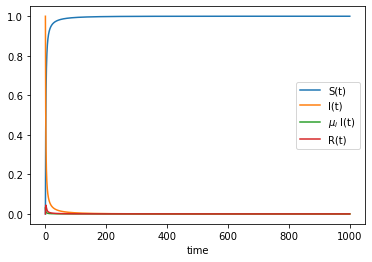

In [4]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt


mu = 0.8 #0.1 
mu_i = 0.03 #0.2
gamma = 0.1 #0.5
beta = 0.92#0.1
sigma = 0.15#0.3
print((mu+mu_i+gamma)/beta)
#print(s[9999])
print(mu*(1-(mu+mu_i+gamma)/beta)/(mu+mu_i+mu*gamma/(mu+sigma)))
print(mu*gamma*(1-(mu+mu_i+gamma)/beta)/((mu+mu_i)*(mu+sigma)+mu*gamma))
#print(i[9999])
def sir(x,t):
    s = x[0]
    i = x[1]
    r = x[2]
    dsdt = mu - beta*s*i - mu*s + sigma*r
    didt = beta*s*i - (mu+gamma+mu_i)*i
    drdt = gamma*i - (mu+sigma)*r
    return [dsdt,didt,drdt]

x0 = [0.0001, 0.9999, 0] #Toda initial conditions
t = np.linspace(0, 1000, 10000)
x = odeint(sir,x0,t)

s=x[:,0]
i=x[:,1]
r=x[:,2]
plt.plot(t,s, label="S(t)")
plt.plot(t,i, label="I(t)")
plt.plot(t,mu_i*i, label="$\mu_i$ I(t)")
plt.plot(t,r, label="R(t)")
plt.xlabel('time')
plt.legend()
plt.savefig("unstable.png")
plt.show()


0.9722222222222222
0.009043927648578816
0.005167958656330752


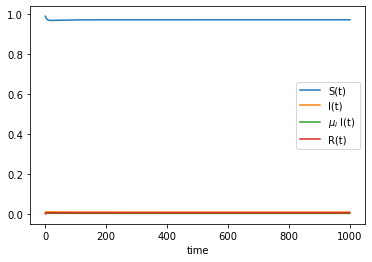

0.9722222224246913


In [13]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt


mu = 0.2 #0.1 
mu_i = 0.3 #0.2
gamma = 0.2 #0.5
beta = mu+mu_i+gamma+0.02
sigma = 0.15#0.3
print((mu+mu_i+gamma)/beta)
print(mu*(1-(mu+mu_i+gamma)/beta)/(mu+mu_i+mu*gamma/(mu+sigma)))
print(mu*gamma*(1-(mu+mu_i+gamma)/beta)/((mu+mu_i)*(mu+sigma)+mu*gamma))
#print(i[9999])
def sir(x,t):
    s = x[0]
    i = x[1]
    r = x[2]
    dsdt = mu - beta*s*i - mu*s + sigma*r
    didt = beta*s*i - (mu+gamma+mu_i)*i
    drdt = gamma*i - (mu+sigma)*r
    return [dsdt,didt,drdt]

x0 = [0.99, 0.01, 0.00] #Toda initial conditions
t = np.linspace(0, 1000, 10000)
x = odeint(sir,x0,t)

s=x[:,0]
i=x[:,1]
r=x[:,2]
plt.plot(t,s, label="S(t)")
plt.plot(t,i, label="I(t)")
plt.plot(t,mu_i*i, label="$\mu_i$ I(t)")
plt.plot(t,r, label="R(t)")
plt.xlabel('time')
plt.legend()
plt.show()
#plt.savefig('unstable2.png') 
print(s[9999])


